In [1]:
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import cm
from collections import Counter
from collections import defaultdict
import numpy as np
import datetime as dt
import geopandas as gpd
import csv
import tqdm
import pandas as pd
import matplotlib
import os

from epiweeks import Week,Year

csv.field_size_limit(sys.maxsize)

131072

In [2]:
uk_map = gpd.read_file("../../Data/UK_geog_data/UK_map.json")
uk_map = uk_map.to_crs("EPSG:3395")
england = uk_map.loc[uk_map["NAME_1"] == "England"]

pc_map = gpd.read_file("../../Data/UK_geog_data/England_postcode_districts.json")
pc_map.crs = "epsg:27700"
pc_map = pc_map.to_crs("epsg:3395")

utla_map = gpd.read_file("../../Data/UK_geog_data/UTLA_administrative_areas.json")
utla_map = utla_map.to_crs("EPSG:3395")
england_utla = utla_map.loc[utla_map['CODE'].str.startswith("E")]


def true_date(date):
    
    year = str(date).split(".")[0]
    decimal = f'0.{str(date).split(".")[1]}'
    
    if year == '2020':
        day_no = float(decimal) * 366
    else:
        day_no = float(decimal) * 365
        
    delta = dt.timedelta(day_no)
    
    start = dt.date(year=int(year), month=1, day=1)
    tr_date = start + delta
    
    return str(tr_date)

def decimal_date(date):
    
    if type(date) == str:
        date = dt.datetime.strptime(date,"%Y-%m-%d").date()
    year = date.year
    if year == 2020:
        div = 366
    else:
        div = 365
    start = dt.date(year=year, month=1, day=1)
    decimal = (date - start).days/div
    
    dec_date = year + decimal
    return dec_date



In [3]:
all_codes = []
code_to_name = {}
name_to_code = {}
ltla_code_to_utla_code = {}
with open("../../Data/LAD_UTLA_adm2.csv") as f:
    data = csv.DictReader(f)
    for l in data:
        if "E" in l['UTLA_code']:
            all_codes.append(l['UTLA_code'])
            code_to_name[l['UTLA_code']] = l['UTLA_name']
            name_to_code[l['UTLA_name']] = l["UTLA_code"]
            ltla_code_to_utla_code[l['LAD_code']] = l['UTLA_code']
            
code_to_name["E13000001|E13000002"] = "GREATER LONDON"
name_to_code["GREATER LONDON"] = "E13000001|E13000002"

In [4]:
ltla_code_to_utla_code["E08000006"]

'E11000001'

In [5]:
for k,v in ltla_code_to_utla_code.items():
    if v == "":
        print(k,v)

In [6]:
list_of_dates = []
start_date = dt.date(2021,3,1)
end_date = dt.date(2021,7,1)
day = dt.timedelta(1)

date_lst = [start_date + dt.timedelta(n) for n in range(int ((end_date - start_date).days))]
date_strings = []
for i in date_lst:
    date_strings.append(i.strftime(format="%Y-%m-%d"))

## get info

In [8]:
utlas_to_intros = defaultdict(list)
shapefile_code_to_name = {}
for file in tqdm.tqdm(os.listdir("../results/MCC_files_all/")):
    if file.endswith(".csv"):
        lin = file.strip(".csv").split("_")[0]
        with open(f"../results/MCC_files_all/{file}") as f:
            data = csv.DictReader(f)
            for l in data:
                if l['end_utla'] != l['start_utla']:
                    if l['end_code'] in ltla_code_to_utla_code:
                        e_code = ltla_code_to_utla_code[l['end_code']]
                    else:
                        e_code = l['end_code']
                    if l['start_code'] in ltla_code_to_utla_code:
                        s_code = ltla_code_to_utla_code[l['start_code']]
                    else:
                        s_code = l['start_code']
                    
                    if e_code != s_code:
                        utlas_to_intros[e_code].append(l['end_real_date'])


100%|██████████| 266/266 [00:03<00:00, 85.51it/s] 


In [9]:
utla_intro_counts = defaultdict(dict)
for utla, dates in utlas_to_intros.items():
    utla_intro_counts[utla] = Counter(dates)

In [38]:
ltla_code_to_utla_code[""]
#these are exports from England - into Wales or Scotland

Counter({'2021-06-01': 7,
         '2021-06-02': 6,
         '2021-06-05': 8,
         '2021-05-23': 3,
         '2021-05-25': 3,
         '2021-06-07': 5,
         '2021-06-03': 5,
         '2021-05-22': 2,
         '2021-06-12': 7,
         '2021-06-06': 8,
         '2021-06-04': 11,
         '2021-06-08': 7,
         '2021-06-10': 6,
         '2021-06-11': 7,
         '2021-06-09': 3,
         '2021-05-28': 2,
         '2021-05-18': 2,
         '2021-05-29': 3,
         '2021-04-24': 1,
         '2021-05-21': 1,
         '2021-05-27': 2,
         '2021-06-14': 4,
         '2021-05-26': 3,
         '2021-05-05': 1,
         '2021-05-19': 1,
         '2021-05-12': 1,
         '2021-05-30': 1,
         '2021-05-24': 1,
         '2021-05-31': 1})

In [10]:
with open("../results/introductions_per_utla.csv", 'w') as fw:
    headers = ["day", "utla", "utla_code", "number_introductions"]
    writer=csv.DictWriter(fw, fieldnames=headers)
    writer.writeheader()
    for code, day_dict in utla_intro_counts.items():
        if code != "":
            for day, count in day_dict.items():
                write_dict = {}
                write_dict["day"] = day
                write_dict["utla"] = code_to_name[code]
                write_dict['utla_code'] = code
                write_dict["number_introductions"] = count

                writer.writerow(write_dict)


## Plot map

In [11]:
london_codes = set()
for i in england_utla.loc[england_utla["FILE_NAME"] == "GREATER_LONDON_AUTHORITY"]["CODE"]:
    london_codes.add(i)

In [12]:
to_merge = []
for i in england_utla["CODE"]:
    if i in london_codes:
        to_merge.append("E13000001")
    elif i in ltla_code_to_utla_code:
        to_merge.append(ltla_code_to_utla_code[i])
    else:
        to_merge.append(i)
#     elif i == "E06000060":
#         to_merge.append("E10000002")

        
england_utla["new_codes"] = to_merge
        

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [14]:
with_new_codes = england_utla.dissolve(by="new_codes")

In [15]:
with_new_codes["CODE"] = with_new_codes.index
with_new_codes.to_file("UTLA_shapes_final")

In [16]:
with_new_codes

,geometry,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1
new_codes,,,,,,,,,,,,,,,,
E06000001,"POLYGON ((-137993.516 7273547.844, -138001.882...",Hartlepool (B),UTA,Unitary Authority,HARTLEPOOL_(B),48,48,125831,25589,E06000001,9834.667,463.404,AA,CIVIL ADMINISTRATION AREA,,
E06000002,"POLYGON ((-127592.575 7231149.718, -127594.618...",Middlesbrough (B),UTA,Unitary Authority,MIDDLESBROUGH_(B),43,43,71579,25586,E06000002,5455.359,67.202,AA,CIVIL ADMINISTRATION AREA,,
E06000003,"POLYGON ((-128904.662 7255416.296, -128907.807...",Redcar and Cleveland (B),UTA,Unitary Authority,REDCAR_AND_CLEVELAND_(B),34,34,71583,25588,E06000003,25378.536,871.585,AA,CIVIL ADMINISTRATION AREA,,
E06000004,"POLYGON ((-137463.164 7232583.398, -137513.985...",Stockton-on-Tees (B),UTA,Unitary Authority,STOCKTON-ON-TEES_(B),95,95,71582,25587,E06000004,20973.081,479.786,AA,CIVIL ADMINISTRATION AREA,,
E06000005,"POLYGON ((-159731.757 7228218.532, -159711.528...",Darlington (B),UTA,Unitary Authority,DARLINGTON_(B),57,57,100101,38404,E06000005,19747.569,0.000,AA,CIVIL ADMINISTRATION AREA,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E11000003,"POLYGON ((-147461.434 7009752.372, -147467.787...",Barnsley District (B),MTD,Metropolitan District,BARNSLEY_DISTRICT_(B),65,65,50242,9182,E11000003,32907.759,0.000,AA,CIVIL ADMINISTRATION AREA,,
E11000005,"POLYGON ((-177609.810 6849080.312, -177603.874...",Birmingham District (B),MTD,Metropolitan District,BIRMINGHAM_DISTRICT_(B),69,69,40111,18,E11000005,26779.106,0.000,AA,CIVIL ADMINISTRATION AREA,,
E11000006,"POLYGON ((-176602.830 7061684.845, -176666.592...",Wakefield District (B),MTD,Metropolitan District,WAKEFIELD_DISTRICT_(B),18,18,61077,16758,E11000006,33861.973,0.000,AA,CIVIL ADMINISTRATION AREA,,


In [17]:
with_new_codes.loc[with_new_codes.index == "E06000008"]

,geometry,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1
new_codes,,,,,,,,,,,,,,,,
E06000008,"POLYGON ((-263965.002 7072906.117, -263985.202...",Blackburn with Darwen (B),UTA,Unitary Authority,BLACKBURN_WITH_DARWEN_(B),29,29,101590,38840,E06000008,13702.208,0.0,AA,CIVIL ADMINISTRATION AREA,,


In [18]:
df_dict = defaultdict(list)
code_to_total = {}
with open("../results/introductions_per_utla.csv") as f:
    data = csv.DictReader(f)
    for l in data:
        total = float(l['number_introductions'])
        code = l['utla_code']
        if "E13000001" in code:
            code = "E13000001"
        
        if code in code_to_total:
            code_to_total[code] += total
        else:
            code_to_total[code] = total
        
for code, total in code_to_total.items(): 
    df_dict["CODE"].append(code)
    df_dict["intro_counts"].append((total))
        
df = pd.DataFrame(df_dict)

In [19]:
together = with_new_codes.merge(df, how='outer')


In [28]:
together.to_csv("total_intro_counts.csv")

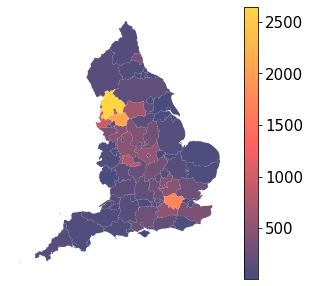

In [21]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
together["geometry"] = together.geometry.simplify(1000)
matplotlib.rcParams.update({'font.size': 15})

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#484C7E","#FE6362", "#FFD544"])

together.plot(ax=ax,column="intro_counts",cmap=cmap, missing_kwds={"color":"lightgrey","label":"Data omitted"}, legend=True)

ax.axis('off')

new_ticks = []

# norm = matplotlib.colors.Normalize(vmin=0, vmax=5)
# bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
# for i in bar.get_ticks():
#     new_ticks.append(int(10**(i)))
# bar.set_ticks(bar.get_ticks())
# bar.set_ticklabels(new_ticks)



plt.savefig("../figures/map_number_introductions.pdf", bbox_inches="tight")

plt.show()
                                                
                                                   

## New utlas sampled in per week 

In [56]:
colours = {
"0_67":"#e2ecf2",
"0_92":"#ffd544",
"0_190":"#fe6362",
"0_322":"#484c7e",
"0_386":"#bbbee9",
"1_51": "#98c1d9",
"2_337": "#293241"  
}

names = {
"0_67":"Lineage IV",
"0_92":"Lineage I",
"0_190":"Lineage II",
"0_322":"Lineage VI",
"0_386":"Lineage VII",
"1_51": "Lineage V",
"2_337": "Lineage III" 
}

colours_renamed = {
"Lineage I":"#ffd544",
"Lineage II":"#fe6362",
"Lineage III":"#293241",
"Lineage V":"#98c1d9",
"Lineage IV":"#e2ecf2",
"Lineage VI":"#484c7e",
"Lineage VII":"#bbbee9"
}

large_lins = ["0_92", "0_190", "2_337", "0_67", "1_51", "0_322", "0_386"]

In [30]:
lineage_to_taxa = defaultdict(list)

for intro in large_lins:
    num_file = intro.split("_")[0]
    rel_file = f'15K_00{num_file}.median_tree.tsv'
    lineage = intro.split("_")[1]
    with open(os.path.join("../input_files/median_import_tree/",rel_file)) as f:
        data = csv.DictReader(f, delimiter="\t")
        for l in data:
            if l['lineage'] == lineage:
                value = l['taxa'].replace(" ","").split(";")
                lineage_to_taxa[intro] = value
        

In [43]:
seq_to_date = {}
for lin, taxa in lineage_to_taxa.items():
    for tax in taxa:
        seq_to_date[tax.split("|")[0]] = dt.datetime.strptime(tax.split("|")[1], "%Y-%m-%d").date()
        

seq_to_loc = {}
with open(GEOGRAPHICAL METADATA) as f:
    data = csv.DictReader(f)
    for l in tqdm.tqdm(data):
        if l['sequence_name'] in seq_to_date:
            if "|" in l['utla'] or l['utla'] == "":
                utla = "ambiguous"
            else:
                utla = l['utla']
            seq_to_loc[f'{l["sequence_name"]}|{seq_to_date[l["sequence_name"]]}'] = utla



2152986it [00:09, 215535.28it/s]


In [51]:
lin_week_loc = defaultdict(dict)

for lineage, taxa in lineage_to_taxa.items():
    if lineage in large_lins:
        week_to_adm2 = defaultdict(set)
        for seq in taxa:
            week = Week.fromdate(seq_to_date[seq.split("|")[0]])
            if seq in seq_to_loc:
                loc = seq_to_loc[seq]
                if loc != "ambiguous":
                    week_to_adm2[week].add(loc)
            else:
                print(seq)
                
        lin_week_loc[lineage] = week_to_adm2

England/BRBR-18E7338/2021|2021-06-11
England/MILK-1E6A470/2021|2021-03-12
England/NORT-1BF2838/2021|2021-06-01
England/QEUH-1947CEF/2021|2021-06-12
England/BRBR-1859ED6/2021|2021-06-02
England/PHEC-33D31D/2021|2021-06-14
England/MILK-1990573/2021|2021-06-13


In [57]:
lin_to_cumulative = defaultdict(dict)

for lineage in large_lins:
# for lineage, week_dict in lin_week_loc.items():
    week_dict = lin_week_loc[lineage]
    already_in = set()
    cum_locs = defaultdict(set)
    diff_locs = {}
    
    for week, loc_set in sorted(week_dict.items()):
        new_lst = []
        last_week = len(already_in)
        for loc in loc_set:
            already_in.add(loc)

        for i in already_in:
            new_lst.append(i)
            
        cum_locs[week.startdate()] = len(new_lst)
        

    lin_to_cumulative[lineage] = cum_locs



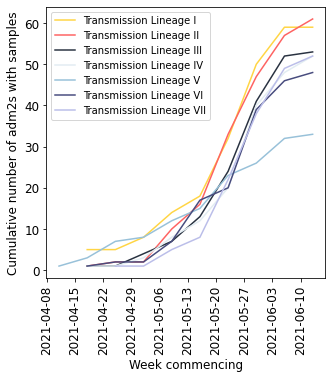

In [58]:
fig, ax = plt.subplots(1,figsize=(5,5))
loc = plticker.MultipleLocator(base=7.0)

for lin, lin_dict in lin_to_cumulative.items():

    x = list(lin_dict.keys())
    y = list(lin_dict.values())
    plt.plot(x,y, color=colours[lin], label=f'Transmission {names[lin]}')
    

plt.legend()
plt.xticks(rotation=90, size=12)
plt.yticks(size=12)
plt.xlabel("Week commencing", size=12)
plt.ylabel("Cumulative number of adm2s with samples", size=12)

ax.xaxis.set_major_locator(loc)


plt.savefig(f"../figures/new_adm2s_absolute_time.pdf", bbox_inches="tight")
    
plt.show()



In [59]:
relative = defaultdict(dict)
for lin, lin_dict in lin_to_cumulative.items():
    new_dict = {}
    count = 0
    for i,v in lin_dict.items():
        count += 1
        new_dict[count] = v
        
    relative[lin] = new_dict

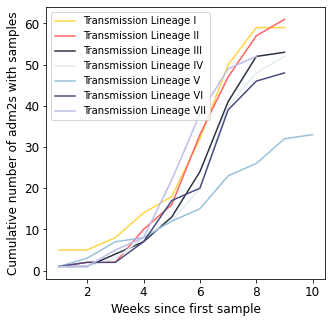

In [60]:
fig, ax = plt.subplots(1,figsize=(5,5))

for lin, lin_dict in relative.items():
    
    x = list(lin_dict.keys())
    y = list(lin_dict.values())
    plt.plot(x,y, color=colours[lin], label=f'Transmission {names[lin]}')
    
    
plt.legend()
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Weeks since first sample", size=12)
plt.ylabel("Cumulative number of adm2s with samples", size=12)
plt.savefig(f"../figures/new_utlas_relative_time.pdf", bbox_inches = "tight")


plt.show()

In [11]:
locations = []
with open("../results/MCC_files_all/1_51_mcc_data.csv") as f:
    data = csv.DictReader(f)
    print(data.fieldnames)
    for l in data:
        locations.append(l['start_utla'])
        
    

['node1', 'node2', 'length', 'start_long_3395', 'start_lat_3395', 'end_lat_3395', 'end_long_3395', 'start_lat_4326', 'start_long_4326', 'end_long_4326', 'end_lat_4326', 'start_adm2', 'end_adm2', 'start_pc', 'end_pc', 'start_utla', 'end_utla', 'start_code', 'end_code', 'start_dec_date', 'end_dec_date', 'start_real_date', 'end_real_date']


In [12]:
location_counts = Counter(locations)

In [17]:
sorted_dict = {k: v for k, v in sorted(location_counts.items(), key=lambda item: item[1], reverse=True)}

In [18]:
sorted_dict

{'BEDFORD_(B)': 1974,
 'CENTRAL_BEDFORDSHIRE': 408,
 'BUCKINGHAMSHIRE': 200,
 'NORTHAMPTONSHIRE_COUNTY': 192,
 'HERTFORDSHIRE_COUNTY': 172,
 'GREATER_LONDON_AUTHORITY': 156,
 'MILTON_KEYNES_(B)': 76,
 'ESSEX_COUNTY': 42,
 'LUTON_(B)': 28,
 'MEDWAY_(B)': 26,
 'OXFORDSHIRE_COUNTY': 24,
 'CITY_OF_PETERBOROUGH_(B)': 14,
 'CAMBRIDGESHIRE_COUNTY': 8,
 'LINCOLNSHIRE_COUNTY': 8,
 'COVENTRY_DISTRICT_(B)': 6,
 'GLOUCESTERSHIRE_COUNTY': 4,
 'HALTON_(B)': 4,
 'LANCASHIRE_COUNTY': 4,
 'LEEDS_DISTRICT_(B)': 2,
 'WARWICKSHIRE_COUNTY': 2,
 'KENT_COUNTY': 2,
 'NORFOLK_COUNTY': 2,
 'CHESHIRE_WEST_AND_CHESTER_(B)': 2,
 'SURREY_COUNTY': 2}